# Diagnosing Covid-19 from Lung CT Scans using transfer learning (VGG16, DenseNet121, InceptionV3, etc.)

Disclaimer :

Model checkpoints have been saved for the epoch in which validation accuracy was the highest however in this project, for the evaluation/ comparative evaluation of the models we used the weights for the final model i.e. after 200 epochs of training.

In [ ]:
# (Reasoning not correct / comment to dicardd)
# This has been done primarily, because of considerably high fluctuation in the 
# validation accuracy curves in the initial epochs, 
# whereas in the later epochs although the fluctuation was present, 
# it seemed to fluctuate around a certain value signalling convergence.

# Setting seeds

In [3]:
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

# Importing Libraries

In [4]:
#For data/image preprocessing 
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#For building models
import tensorflow as tf
from tensorflow.keras import layers, Sequential

#Visualization
import matplotlib.pyplot as plt

#Model evaluation
from sklearn.metrics import accuracy_score,  recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

#Misc
import glob
import pickle
import itertools

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the dataset

The dataset is available at https://www.kaggle.com/luisblanche/covidct

In [ ]:
from google.colab import files
files.upload() #to upload kaggle.json file 

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#gives full read & write access to the file
! chmod 600 ~/.kaggle/kaggle.json

import kaggle

#to test if kaggle API is connected to colab
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              224KB  2021-04-24 17:07:26           3523  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2061  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            420  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1321  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
#download the dataset
! kaggle datasets download -d luisblanche/covidct

 86% 74.0M/85.8M [00:00<00:00, 91.7MB/s]
100% 85.8M/85.8M [00:00<00:00, 175MB/s] 


In [ ]:
%%capture
! unzip /content/covidct.zip

In [ ]:
! rm /content/covidct.zip

# Data Preprocessing

In [ ]:
covid_imgs_path = sorted(glob.glob('/content/CT_COVID/*'))
noncovid_imgs_path = sorted(glob.glob('/content/CT_NonCOVID/*'))

print(len(covid_imgs_path))
print(len(noncovid_imgs_path))

349
397


In [ ]:
#height of all images
h1 = [cv2.imread(f).shape[0] for f in covid_imgs_path]
h2 = [cv2.imread(f).shape[0] for f in noncovid_imgs_path]
h = h1 + h2
len(h)

746

In [ ]:
med_h = np.median(h)
med_h = int(med_h)
med_h

291

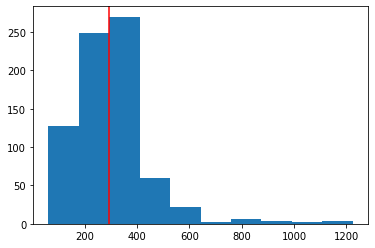

In [ ]:
plt.hist(h)
plt.axvline(x=med_h, color = 'red')

In [ ]:
#width of all images
w1 = [cv2.imread(f).shape[1] for f in covid_imgs_path]
w2 = [cv2.imread(f).shape[1] for f in noncovid_imgs_path]
w = w1 + w2
len(w)

746

In [ ]:
med_w = np.median(w)
med_w = int(med_w)
med_w

407

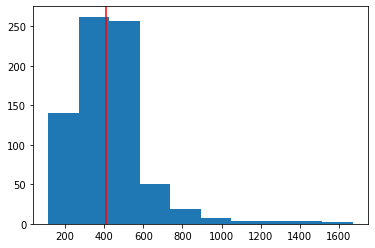

In [ ]:
plt.hist(w)
plt.axvline(x=med_w, color = 'red')

In [ ]:
#No. of colour channels in all images
print(np.unique([cv2.imread(f).shape[2] for f in covid_imgs_path]))
print(np.unique([cv2.imread(f).shape[2] for f in noncovid_imgs_path]))

[3]
[3]


Visualizing images

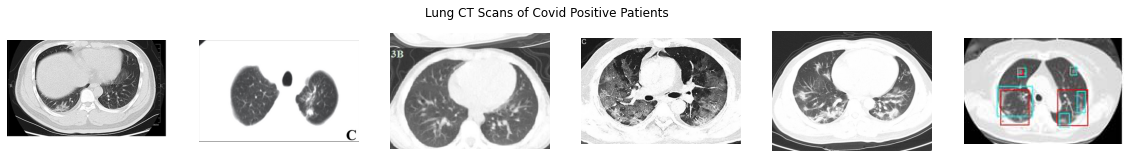

In [ ]:
paths = np.random.choice(covid_imgs_path,6,replace=False)
fig, axs = plt.subplots(1,6, figsize=(20,7))
axs = axs.ravel()
plt.suptitle('Lung CT Scans of Covid Positive Patients')
for idx,path in enumerate(paths) :
  axs[idx].imshow(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB))
  axs[idx].axis('off')

plt.subplots_adjust(top=1.5)
plt.show()

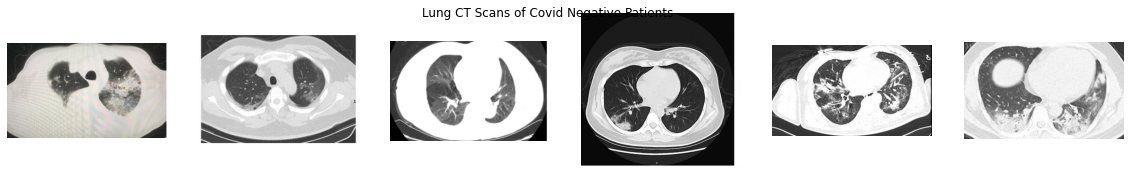

In [ ]:
paths = np.random.choice(covid_imgs_path,6,replace=False)
fig, axs = plt.subplots(1,6, figsize=(20,7))
axs = axs.ravel()
plt.suptitle('Lung CT Scans of Covid Negative Patients')
for idx,path in enumerate(paths) :
  axs[idx].imshow(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB))
  axs[idx].axis('off')

plt.subplots_adjust(top=1.5)
plt.show()

In [ ]:
IMG_SIZE = (med_h, med_w)
IMG_SIZE_CV2 = (med_w, med_h) #In OpenCV image dimension ordering is reversed

In [ ]:
def process_image(path):

    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, IMG_SIZE_CV2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img/255.0 #Scaling the pixel values

    return img

In [ ]:
#Loading and pre-processing images from paths
cov_imgs = []
noncov_imgs = []

for f in covid_imgs_path:
    cov_imgs.append(process_image(f))

for f in noncovid_imgs_path:
    noncov_imgs.append(process_image(f))
    
cov_imgs = np.asarray(cov_imgs)
cov_labels = np.ones(cov_imgs.shape[0])

noncov_imgs = np.asarray(noncov_imgs)
noncov_labels = np.zeros(noncov_imgs.shape[0])

imgs = np.concatenate((cov_imgs, noncov_imgs), axis=0)
labels = np.concatenate((cov_labels, noncov_labels), axis=0)

print(imgs.shape)
print(labels.shape)

(746, 291, 407, 3)
(746,)


In [ ]:
#shuffle the dataset
imgs, labels = shuffle(imgs, labels, random_state=1)

In [ ]:
#Values greater than 255.0
print(np.unique(imgs[imgs>255.0])) #List of values > 255.0
print(imgs[imgs>255.0].shape)

[255.00002 255.00003]
(1400,)


almost equal to 255.0

In [ ]:
np.min(imgs)

0.0

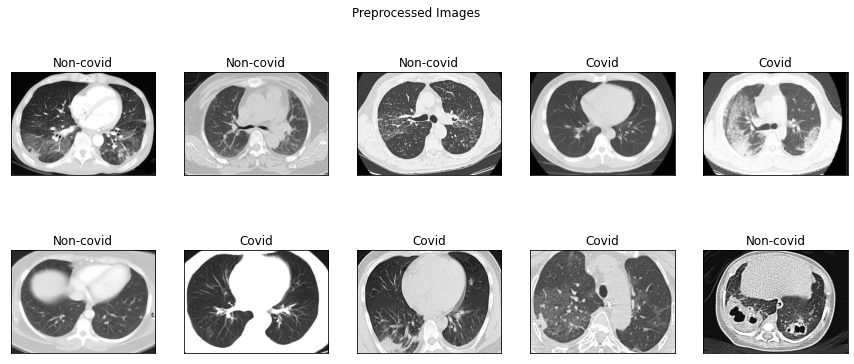

In [ ]:
#display preprocessed images
idxs = np.random.choice(np.arange(0,len(imgs)),10,replace=False)

fig, ax = plt.subplots(2, 5, figsize=(15,6))
ax = ax.ravel()

for i, idx in enumerate(idxs):
    ax[i].imshow(np.squeeze(imgs[idx]/255.0))
    ax[i].set_title('Covid' if labels[idx] == 1 else 'Non-covid')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

plt.suptitle('Preprocessed Images')
plt.show()

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=100, random_state=345)

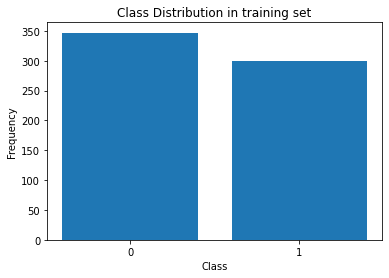

In [ ]:
y_train_freq = np.unique(y_train,return_counts=True)
plt.bar(y_train_freq[0],y_train_freq[1])
plt.xticks(y_train_freq[0], [0,1])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in training set')
plt.show()

In [ ]:
y_train_freq[1]

array([347, 299])

Distribution of classes are not that unbalanced

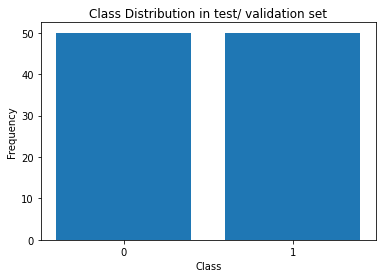

In [ ]:
y_test_freq = np.unique(y_test,return_counts=True)
plt.bar(y_test_freq[0],y_test_freq[1])
plt.xticks(y_test_freq[0], [0,1])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in test/ validation set')
plt.show()

Distribution of classes almost equal in test set.

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(646, 291, 407, 3)
(646,)
(100, 291, 407, 3)
(100,)


# Training

## Baseline Model

### Setup & Preprocessing

In [ ]:
!mkdir /content/baselinenet

In [ ]:
X_train_p = X_train/255.0
X_test_p = X_test/255.0
print(X_train_p.shape)
print(X_test_p.shape)

(646, 291, 407, 3)
(100, 291, 407, 3)


In [ ]:
baselinenet = Sequential()

baselinenet.add(layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(med_h, med_w, 3))),
baselinenet.add(layers.MaxPooling2D(pool_size=(2,2))),
baselinenet.add(layers.BatchNormalization()),

baselinenet.add(layers.Conv2D(128, 3, padding='same', activation='relu')),
baselinenet.add(layers.MaxPooling2D(pool_size=(2,2))),
baselinenet.add(layers.BatchNormalization()),

baselinenet.add(layers.GlobalAveragePooling2D()),
baselinenet.add(layers.Dropout(0.5)),
baselinenet.add(layers.Dense(64, activation='relu')),
baselinenet.add(layers.Dense(1, activation= 'sigmoid'))
baselinenet.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 291, 407, 64)      1792      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 145, 203, 64)      0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 145, 203, 64)      256       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 145, 203, 128)     73856     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 72, 101, 128)      0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 72, 101, 128)      512       
_________________________________________________________________
global_average_pooling2d_7 ( (None, 128)             

In [ ]:
baselinenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20)
lr_dec_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=20)
chkpt_save = tf.keras.callbacks.ModelCheckpoint("/content/baselinenet/baselinenet_ftr_extrctd/chkpt1", monitor="val_accuracy", save_best_only=True, mode = 'max', save_weights_only = True)

callbacks_list = [lr_dec_plateau, chkpt_save]

### Training

In [ ]:
num_epochs = 200
num_batch_size = 32 

In [ ]:
history = baselinenet.fit(X_train_p, y_train,
                          epochs=num_epochs,
                          batch_size=num_batch_size,
                          validation_data=(X_test_p, y_test),
                          callbacks=callbacks_list)

Epoch 1/200
21/21 [==============================] - 4s 135ms/step - loss: 0.6875 - accuracy: 0.5759 - val_loss: 0.7352 - val_accuracy: 0.5300
Epoch 2/200
21/21 [==============================] - 2s 110ms/step - loss: 0.6134 - accuracy: 0.6618 - val_loss: 0.6622 - val_accuracy: 0.6100
Epoch 3/200
21/21 [==============================] - 2s 109ms/step - loss: 0.5891 - accuracy: 0.6701 - val_loss: 0.7337 - val_accuracy: 0.5000
Epoch 4/200
21/21 [==============================] - 2s 110ms/step - loss: 0.6052 - accuracy: 0.6849 - val_loss: 0.7851 - val_accuracy: 0.5000
Epoch 5/200
21/21 [==============================] - 2s 109ms/step - loss: 0.5836 - accuracy: 0.6833 - val_loss: 0.8214 - val_accuracy: 0.5000
Epoch 6/200
21/21 [==============================] - 2s 109ms/step - loss: 0.5864 - accuracy: 0.6783 - val_loss: 0.8920 - val_accuracy: 0.5000
Epoch 7/200
21/21 [==============================] - 2s 109ms/step - loss: 0.5660 - accuracy: 0.6834 - val_loss: 0.9865 - val_accuracy: 0.5000

In [ ]:
#saving history to plot losses/ metrics later
with open('/content/baselinenet/baselinenet_history.hist', 'wb') as f1:
  pickle.dump(history.history, f1)

### Reloading the model

In [ ]:
checkpoint_path_baselinenet = '/content/baselinenet/baselinenet_ftr_extrctd/chkpt1'
baselinenet.load_weights(checkpoint_path_baselinenet)

In [ ]:
with open('/content/baselinenet/baselinenet_history.hist', 'rb') as f1:
  history_hist = pickle.load(f1)

In [ ]:
with open('/content/baselinenet/baselinenet_metrics.pickle','rb') as f:
  baselinenet_metrics = pickle.load(f)

### Evaluation

In [ ]:
# Re-evaluate the model
loss_train_baselinenet, acc_train_baselinenet = baselinenet.evaluate(X_train_p, y_train, verbose=2)

21/21 - 1s - loss: 0.3878 - accuracy: 0.8111


In [ ]:
# Re-evaluate the model
loss_baselinenet, acc_baselinenet = baselinenet.evaluate(X_test_p, y_test, verbose=2)

4/4 - 0s - loss: 0.7257 - accuracy: 0.7500


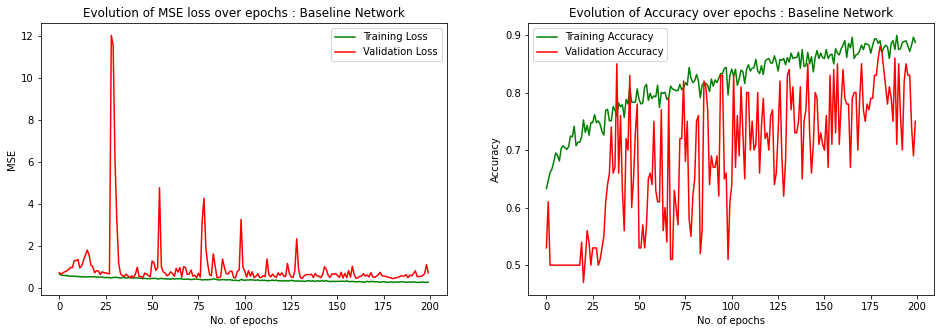

In [ ]:
#history_hist = history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

#MSE Loss
train_loss = history_hist['loss']
val_loss = history_hist['val_loss']


ax1.plot(range(0,len(train_loss)), train_loss, 'g', label='Training Loss')
ax1.plot(range(0,len(val_loss)), val_loss, 'r', label='Validation Loss')
ax1.set_title('Evolution of MSE loss over epochs : Baseline Network')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('MSE')
ax1.legend()

#Accuracy
train_acc = history_hist['accuracy']
val_acc = history_hist['val_accuracy']

ax2.plot(range(0,len(train_acc)), train_acc, 'g', label='Training Accuracy')
ax2.plot(range(0,len(val_acc)), val_acc, 'r', label='Validation Accuracy')
ax2.set_title('Evolution of Accuracy over epochs : Baseline Network')
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
y_pred_prob = baselinenet.predict(X_test_p).flatten()
y_pred =(y_pred_prob > 0.5).astype("int32") # 0.5 threhold

<Figure size 432x288 with 0 Axes>

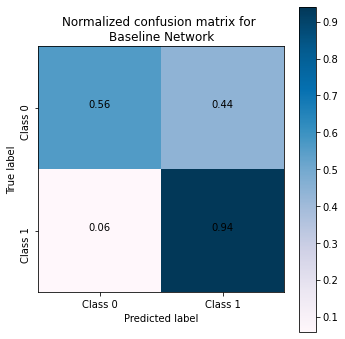

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.PuBu):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'], title='Normalized confusion matrix for \nBaseline Network')
plt.show()

In [ ]:
fpr_baselinenet, tpr_baselinenet, thresholds = roc_curve(y_test, y_pred_prob)
auc_val_baselinenet = auc(fpr_baselinenet, tpr_baselinenet)

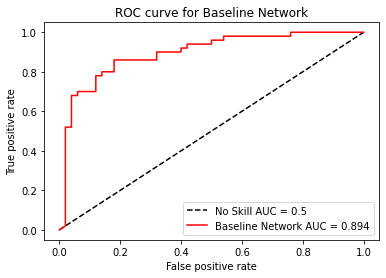

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr_baselinenet, tpr_baselinenet, label='Baseline Network AUC = {:.3f}'.format(auc_val_baselinenet), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Baseline Network')
plt.legend(loc='best')
plt.show()

In [ ]:
# accuracy: (tp + tn) / (tp + tn + fp +fn)
acc_baselinenet = accuracy_score(y_test, y_pred)
print('Accuracy : %f' % acc_baselinenet)

# f1: 2 tp / (2 tp + fp + fn)
f1_baselinenet = f1_score(y_test, y_pred)
print('F1 score : %f' % f1_baselinenet)

# recall: tp / (tp + fn)
recall_baselinenet = recall_score(y_test, y_pred)
print('Recall : %f' % recall_baselinenet)

# AUC
print('AUC : %f' % auc_val_baselinenet)

Accuracy : 0.750000
F1 score : 0.789916
Recall : 0.940000
AUC : 0.893800


In [ ]:
baselinenet_metrics = dict({'acc_baselinenet' : acc_baselinenet,
                    'f1_baselinenet' : f1_baselinenet,
                    'recall_baselinenet' : recall_baselinenet,
                    'auc_val_baselinenet' : auc_val_baselinenet,
                    'fpr_baselinenet' : fpr_baselinenet,
                    'tpr_baselinenet' : tpr_baselinenet})

In [ ]:
with open('/content/baselinenet/baselinenet_metrics.pickle','wb') as f:
  pickle.dump(baselinenet_metrics, f)

In [ ]:
%%capture
! zip -r /content/baselinenet.zip /content/baselinenet/
! rm -rf /content/baselinenet/

## VGG16

### Setup & Preprocessing

In [ ]:
!mkdir /content/vgg16

In [ ]:
X_train_p = tf.keras.applications.vgg16.preprocess_input(X_train)
X_test_p = tf.keras.applications.vgg16.preprocess_input(X_test)
print(X_train_p.shape)
print(X_test_p.shape)

(646, 291, 407, 3)
(100, 291, 407, 3)


In [ ]:
# build the VGG16 network
vgg_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape = (med_h, med_w, 3))
vgg_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 291, 407, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 291, 407, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 291, 407, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 145, 203, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 145, 203, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 145, 203, 128)     147584    
______________________________________________________________

In [ ]:
for layer in vgg_base.layers:
    layer.trainable = False

In [ ]:
vgg = Sequential()
vgg.add(vgg_base)
#vgg.layers[0].trainable = False
vgg.add(layers.GlobalAveragePooling2D())
vgg.add(layers.Dense(256, activation='relu'))
vgg.add(layers.Dropout(0.5))
vgg.add(layers.Dense(128, activation='relu'))
vgg.add(layers.Dropout(0.5))
vgg.add(layers.Dense(64, activation='relu'))
vgg.add(layers.Dense(1, activation='sigmoid'))
vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 12, 512)        14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [ ]:
vgg.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20)
lr_dec_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=20)
chkpt_save = tf.keras.callbacks.ModelCheckpoint("/content/vgg16/vgg16_ftr_extrctd/chkpt1", monitor="val_accuracy", save_best_only=True, mode = 'max', save_weights_only = True)

callbacks_list = [lr_dec_plateau, chkpt_save]

### Training

In [ ]:
num_epochs = 200
num_batch_size = 32 

In [ ]:
history = vgg.fit(X_train_p, y_train,
                  epochs=num_epochs,
                  batch_size=num_batch_size,
                  validation_data=(X_test_p, y_test),
                  callbacks=callbacks_list)

Epoch 1/200
21/21 [==============================] - 27s 305ms/step - loss: 1.3131 - accuracy: 0.5294 - val_loss: 0.7474 - val_accuracy: 0.5500
Epoch 2/200
21/21 [==============================] - 4s 170ms/step - loss: 0.9015 - accuracy: 0.5460 - val_loss: 0.5548 - val_accuracy: 0.7400
Epoch 3/200
21/21 [==============================] - 4s 170ms/step - loss: 0.7132 - accuracy: 0.6342 - val_loss: 0.5210 - val_accuracy: 0.7700
Epoch 4/200
21/21 [==============================] - 4s 170ms/step - loss: 0.7017 - accuracy: 0.6282 - val_loss: 0.4977 - val_accuracy: 0.7700
Epoch 5/200
21/21 [==============================] - 4s 170ms/step - loss: 0.5835 - accuracy: 0.6879 - val_loss: 0.5629 - val_accuracy: 0.6600
Epoch 6/200
21/21 [==============================] - 4s 169ms/step - loss: 0.6280 - accuracy: 0.7182 - val_loss: 0.5648 - val_accuracy: 0.7300
Epoch 7/200
21/21 [==============================] - 4s 170ms/step - loss: 0.5892 - accuracy: 0.7004 - val_loss: 0.6525 - val_accuracy: 0.650

In [ ]:
#saving history to plot losses/ metrics later
with open('/content/vgg16/vgg16_history.hist', 'wb') as f1:
  pickle.dump(history.history, f1)

### Reloading the model

In [ ]:
checkpoint_path_vgg = '/content/vgg16/vgg16_ftr_extrctd/chkpt1'
vgg.load_weights(checkpoint_path_vgg)

In [ ]:
with open('/content/vgg16/vgg16_history.hist', 'rb') as f1:
  history_hist = pickle.load(f1)

In [ ]:
with open('/content/vgg16/vgg_metrics.pickle','rb') as f:
  vgg_metrics = pickle.load(f)

### Evaluation

In [ ]:
# Re-evaluate the model
loss_train_vgg, acc_train_vgg = vgg.evaluate(X_train_p, y_train, verbose=2)

21/21 - 3s - loss: 8.2122e-08 - accuracy: 1.0000


In [ ]:
# Re-evaluate the model
loss_vgg, acc_vgg = vgg.evaluate(X_test_p, y_test, verbose=2)

4/4 - 0s - loss: 2.3183 - accuracy: 0.8600


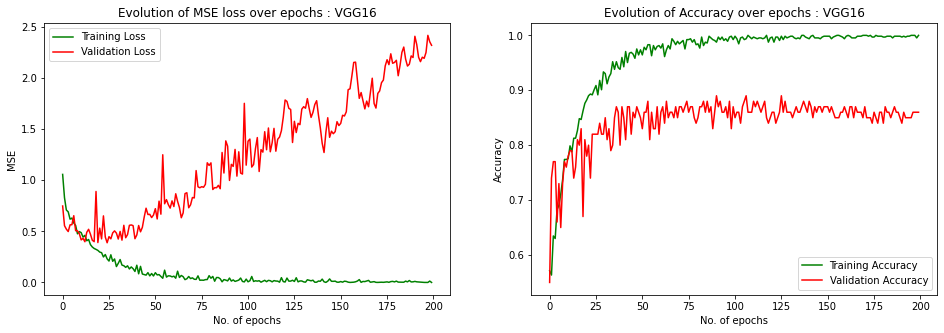

In [ ]:
#history_hist = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

#MSE Loss
train_loss = history_hist['loss']
val_loss = history_hist['val_loss']


ax1.plot(range(0,len(train_loss)), train_loss, 'g', label='Training Loss')
ax1.plot(range(0,len(val_loss)), val_loss, 'r', label='Validation Loss')
ax1.set_title('Evolution of MSE loss over epochs : VGG16')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('MSE')
ax1.legend()

#Accuracy
train_acc = history_hist['accuracy']
val_acc = history_hist['val_accuracy']

ax2.plot(range(0,len(train_acc)), train_acc, 'g', label='Training Accuracy')
ax2.plot(range(0,len(val_acc)), val_acc, 'r', label='Validation Accuracy')
ax2.set_title('Evolution of Accuracy over epochs : VGG16')
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
y_pred_prob = vgg.predict(X_test_p).flatten()
y_pred =(y_pred_prob > 0.5).astype("int32") # 0.5 threhold

<Figure size 432x288 with 0 Axes>

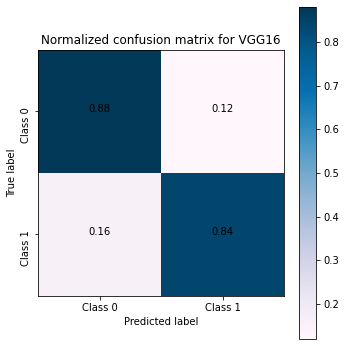

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.PuBu):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'], title='Normalized confusion matrix for VGG16')
plt.show()

In [ ]:
fpr_vgg, tpr_vgg, thresholds = roc_curve(y_test, y_pred_prob)
auc_val_vgg = auc(fpr_vgg, tpr_vgg)

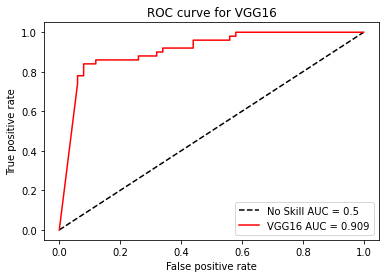

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr_vgg, tpr_vgg, label='VGG16 AUC = {:.3f}'.format(auc_val_vgg), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for VGG16')
plt.legend(loc='best')
plt.show()

In [ ]:
# accuracy: (tp + tn) / (tp + tn + fp +fn)
acc_vgg = accuracy_score(y_test, y_pred)
print('Accuracy : %f' % acc_vgg)

# f1: 2 tp / (2 tp + fp + fn)
f1_vgg = f1_score(y_test, y_pred)
print('F1 score : %f' % f1_vgg)

# recall: tp / (tp + fn)
recall_vgg = recall_score(y_test, y_pred)
print('Recall : %f' % recall_vgg)

# AUC
print('AUC : %f' % auc_val_vgg)

Accuracy : 0.860000
F1 score : 0.857143
Recall : 0.840000
AUC : 0.909400


In [ ]:
vgg_metrics = dict({'acc_vgg' : acc_vgg,
                    'f1_vgg' : f1_vgg,
                    'recall_vgg' : recall_vgg,
                    'auc_val_vgg' : auc_val_vgg,
                    'fpr_vgg' : fpr_vgg,
                    'tpr_vgg' : tpr_vgg})

In [ ]:
with open('/content/vgg16/vgg_metrics.pickle','wb') as f:
  pickle.dump(vgg_metrics, f)

In [ ]:
%%capture
! zip -r /content/vgg16.zip /content/vgg16/
! rm -rf /content/vgg16/

## DenseNet121

### Setup & Preprocessing

In [ ]:
!mkdir /content/densenet121

In [ ]:
X_train_p = tf.keras.applications.densenet.preprocess_input(X_train)
X_test_p = tf.keras.applications.densenet.preprocess_input(X_test)
print(X_train_p.shape)
print(X_test_p.shape)

(646, 291, 407, 3)
(100, 291, 407, 3)


In [ ]:
# build the VGG16 network
densenet_base = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape = (med_h, med_w, 3))
densenet_base.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 291, 407, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 297, 413, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 146, 204, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 146, 204, 64) 256         conv1/conv[0][0]                 
_______________________

In [ ]:
for layer in densenet_base.layers:
    layer.trainable = False

In [ ]:
densenet = Sequential()
densenet.add(densenet_base)
#vgg.layers[0].trainable = False
densenet.add(layers.GlobalAveragePooling2D())
densenet.add(layers.Dense(512, activation='relu'))
densenet.add(layers.Dropout(0.5))
densenet.add(layers.Dense(256, activation='relu'))
densenet.add(layers.Dropout(0.5))
densenet.add(layers.Dense(128, activation='relu'))
densenet.add(layers.Dropout(0.5))
densenet.add(layers.Dense(64, activation='relu'))
densenet.add(layers.Dense(1, activation='sigmoid'))
densenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 9, 12, 1024)       7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [ ]:
densenet.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20)
lr_dec_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=20)
chkpt_save = tf.keras.callbacks.ModelCheckpoint("/content/densenet121/densenet121_ftr_extrctd/chkpt1", monitor="val_accuracy", save_best_only=True, mode = 'max', save_weights_only = True)

callbacks_list = [lr_dec_plateau, chkpt_save]

### Training

In [ ]:
num_epochs = 200
num_batch_size = 32 

In [ ]:
history = densenet.fit(X_train_p, y_train,
                  epochs=num_epochs,
                  batch_size=num_batch_size,
                  validation_data=(X_test_p, y_test),
                  callbacks=callbacks_list)

Epoch 1/200
21/21 [==============================] - 11s 265ms/step - loss: 0.9418 - accuracy: 0.5076 - val_loss: 0.7007 - val_accuracy: 0.5000
Epoch 2/200
21/21 [==============================] - 3s 132ms/step - loss: 0.7393 - accuracy: 0.5594 - val_loss: 0.6668 - val_accuracy: 0.5500
Epoch 3/200
21/21 [==============================] - 3s 132ms/step - loss: 0.7546 - accuracy: 0.5142 - val_loss: 0.7139 - val_accuracy: 0.5000
Epoch 4/200
21/21 [==============================] - 3s 133ms/step - loss: 0.7455 - accuracy: 0.5554 - val_loss: 0.6767 - val_accuracy: 0.5800
Epoch 5/200
21/21 [==============================] - 3s 132ms/step - loss: 0.6962 - accuracy: 0.5571 - val_loss: 0.6458 - val_accuracy: 0.6300
Epoch 6/200
21/21 [==============================] - 3s 133ms/step - loss: 0.7203 - accuracy: 0.5425 - val_loss: 0.6416 - val_accuracy: 0.5600
Epoch 7/200
21/21 [==============================] - 3s 132ms/step - loss: 0.6590 - accuracy: 0.6158 - val_loss: 0.7880 - val_accuracy: 0.560

In [ ]:
#saving history to plot losses/ metrics later
with open('/content/densenet121/densenet121_history.hist', 'wb') as f1:
  pickle.dump(history.history, f1)

### Reloading the model

In [ ]:
checkpoint_path_densenet = '/content/densenet121/densenet121_ftr_extrctd/chkpt1'
densenet.load_weights(checkpoint_path_densenet)

In [ ]:
with open('/content/densenet121/densenet121_history.hist', 'rb') as f1:
  history_hist = pickle.load(f1)

In [ ]:
with open('/content/densenet121/densenet_metrics.pickle','rb') as f:
  densenet_metrics = pickle.load(f)

### Evaluation

In [ ]:
# Re-evaluate the model
loss_train_densenet, acc_train_densenet = densenet.evaluate(X_train_p, y_train, verbose=2)

21/21 - 2s - loss: 1.8961e-05 - accuracy: 1.0000


In [ ]:
# Re-evaluate the model
loss_densenet, acc_densenet = densenet.evaluate(X_test_p, y_test, verbose=2)

4/4 - 0s - loss: 2.3982 - accuracy: 0.8800


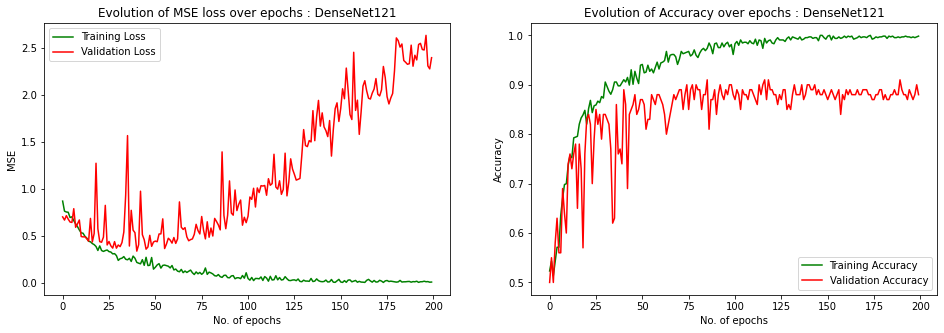

In [ ]:
#history_hist = history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

#MSE Loss
train_loss = history_hist['loss']
val_loss = history_hist['val_loss']


ax1.plot(range(0,len(train_loss)), train_loss, 'g', label='Training Loss')
ax1.plot(range(0,len(val_loss)), val_loss, 'r', label='Validation Loss')
ax1.set_title('Evolution of MSE loss over epochs : DenseNet121')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('MSE')
ax1.legend()

#Accuracy
train_acc = history_hist['accuracy']
val_acc = history_hist['val_accuracy']

ax2.plot(range(0,len(train_acc)), train_acc, 'g', label='Training Accuracy')
ax2.plot(range(0,len(val_acc)), val_acc, 'r', label='Validation Accuracy')
ax2.set_title('Evolution of Accuracy over epochs : DenseNet121')
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
y_pred_prob = densenet.predict(X_test_p).flatten()
y_pred =(y_pred_prob > 0.5).astype("int32") # 0.5 threhold

<Figure size 432x288 with 0 Axes>

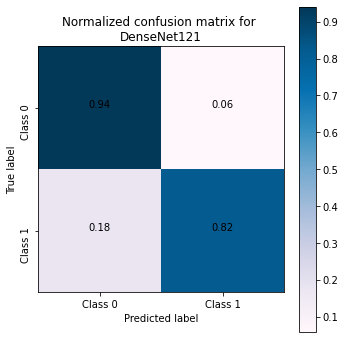

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.PuBu):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'], title='Normalized confusion matrix for \nDenseNet121')
plt.show()

In [ ]:
fpr_densenet, tpr_densenet, thresholds = roc_curve(y_test, y_pred_prob)
auc_val_densenet = auc(fpr_densenet, tpr_densenet)

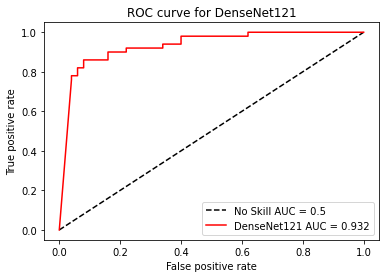

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr_densenet, tpr_densenet, label='DenseNet121 AUC = {:.3f}'.format(auc_val_densenet), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for DenseNet121')
plt.legend(loc='best')
plt.show()

In [ ]:
# accuracy: (tp + tn) / (tp + tn + fp +fn)
acc_densenet = accuracy_score(y_test, y_pred)
print('Accuracy : %f' % acc_densenet)

# f1: 2 tp / (2 tp + fp + fn)
f1_densenet = f1_score(y_test, y_pred)
print('F1 score : %f' % f1_densenet)

# recall: tp / (tp + fn)
recall_densenet = recall_score(y_test, y_pred)
print('Recall : %f' % recall_densenet)

# AUC
print('AUC : %f' % auc_val_densenet)

Accuracy : 0.880000
F1 score : 0.872340
Recall : 0.820000
AUC : 0.932400


In [ ]:
densenet_metrics = dict({'acc_densenet' : acc_densenet,
                    'f1_densenet' : f1_densenet,
                    'recall_densenet' : recall_densenet,
                    'auc_val_densenet' : auc_val_densenet,
                    'fpr_densenet' : fpr_densenet,
                    'tpr_densenet' : tpr_densenet})

In [ ]:
with open('/content/densenet121/densenet_metrics.pickle','wb') as f:
  pickle.dump(densenet_metrics, f)

In [ ]:
%%capture
! zip -r /content/densenet121.zip /content/densenet121/
! rm -rf /content/densenet121/

## ResNet50

### Setup & Preprocessing

In [ ]:
! mkdir /content/resnet50

In [ ]:
X_train_p = tf.keras.applications.resnet.preprocess_input(X_train)
X_test_p = tf.keras.applications.resnet.preprocess_input(X_test)
print(X_train_p.shape)
print(X_test_p.shape)

(646, 291, 407, 3)
(100, 291, 407, 3)


In [ ]:
# build the VGG16 network
resnet_base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape = (med_h, med_w, 3))
resnet_base.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 291, 407, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 297, 413, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 146, 204, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 146, 204, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
for layer in resnet_base.layers:
    layer.trainable = False

In [ ]:
resnet = Sequential()
resnet.add(resnet_base)
#vgg.layers[0].trainable = False
resnet.add(layers.GlobalAveragePooling2D())
#resnet.add(layers.Dropout(0.5))
resnet.add(layers.Dense(1024, activation='relu'))
resnet.add(layers.Dropout(0.5))
resnet.add(layers.Dense(512, activation='relu'))
resnet.add(layers.Dropout(0.5))
resnet.add(layers.Dense(256, activation='relu'))
#resnet.add(layers.Dropout(0.5))
resnet.add(layers.Dense(128, activation='relu'))
#resnet.add(layers.Dropout(0.5))
resnet.add(layers.Dense(64, activation='relu'))
resnet.add(layers.Dense(1, activation='sigmoid'))
resnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 13, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)              

In [ ]:
resnet.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20)
lr_dec_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=20)
chkpt_save = tf.keras.callbacks.ModelCheckpoint("/content/resnet50/resnet50_ftr_extrctd/chkpt1", monitor="val_accuracy", save_best_only=True, mode = 'max', save_weights_only = True)

callbacks_list = [lr_dec_plateau, chkpt_save]

### Training

In [ ]:
num_epochs = 200
num_batch_size = 32 

In [ ]:
history = resnet.fit(X_train_p, y_train,
                  epochs=num_epochs,
                  batch_size=num_batch_size,
                  validation_data=(X_test_p, y_test),
                  callbacks=callbacks_list)

Epoch 1/200
21/21 [==============================] - 7s 207ms/step - loss: 0.8991 - accuracy: 0.5046 - val_loss: 0.6891 - val_accuracy: 0.5300
Epoch 2/200
21/21 [==============================] - 3s 142ms/step - loss: 0.7327 - accuracy: 0.4836 - val_loss: 0.6921 - val_accuracy: 0.5500
Epoch 3/200
21/21 [==============================] - 3s 143ms/step - loss: 0.7037 - accuracy: 0.5051 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 4/200
21/21 [==============================] - 3s 142ms/step - loss: 0.7085 - accuracy: 0.5634 - val_loss: 0.6866 - val_accuracy: 0.5500
Epoch 5/200
21/21 [==============================] - 3s 142ms/step - loss: 0.7041 - accuracy: 0.5320 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 6/200
21/21 [==============================] - 3s 143ms/step - loss: 0.7017 - accuracy: 0.5219 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 7/200
21/21 [==============================] - 3s 142ms/step - loss: 0.6926 - accuracy: 0.5261 - val_loss: 0.7284 - val_accuracy: 0.5000

In [ ]:
#saving history to plot losses/ metrics later
with open('/content/resnet50/resnet50_history.hist', 'wb') as f1:
  pickle.dump(history.history, f1)

### Reloading the model

In [ ]:
checkpoint_path_resnet = '/content/resnet50/resnet50_ftr_extrctd/chkpt1'
resnet.load_weights(checkpoint_path_resnet)

In [ ]:
with open('/content/resnet50/resnet50_history.hist', 'rb') as f1:
  history_hist = pickle.load(f1)

In [ ]:
with open('/content/resnet50/resnet_metrics.pickle','rb') as f:
  resnet_metrics = pickle.load(f)

### Evaluation

In [ ]:
# Re-evaluate the model
loss_train_resnet, acc_train_resnet = resnet.evaluate(X_train_p, y_train, verbose=2)

21/21 - 3s - loss: 0.0020 - accuracy: 0.9985


In [ ]:
# Re-evaluate the model
loss_resnet, acc_resnet = resnet.evaluate(X_test_p, y_test, verbose=2)

4/4 - 0s - loss: 3.1413 - accuracy: 0.8700


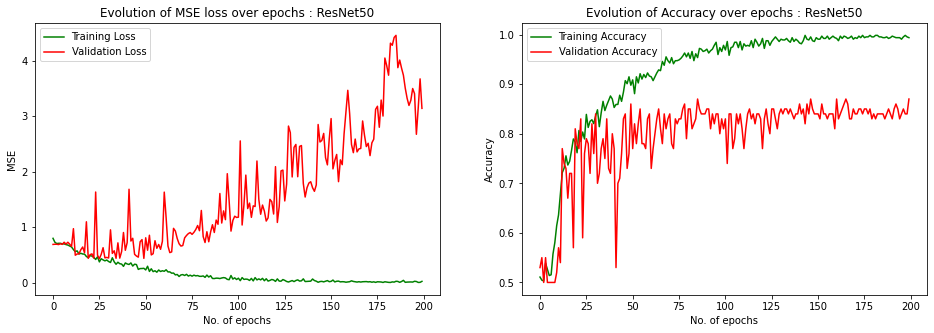

In [ ]:
#history_hist = history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

#MSE Loss
train_loss = history_hist['loss']
val_loss = history_hist['val_loss']


ax1.plot(range(0,len(train_loss)), train_loss, 'g', label='Training Loss')
ax1.plot(range(0,len(val_loss)), val_loss, 'r', label='Validation Loss')
ax1.set_title('Evolution of MSE loss over epochs : ResNet50')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('MSE')
ax1.legend()

#Accuracy
train_acc = history_hist['accuracy']
val_acc = history_hist['val_accuracy']

ax2.plot(range(0,len(train_acc)), train_acc, 'g', label='Training Accuracy')
ax2.plot(range(0,len(val_acc)), val_acc, 'r', label='Validation Accuracy')
ax2.set_title('Evolution of Accuracy over epochs : ResNet50')
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
y_pred_prob = resnet.predict(X_test_p).flatten()
y_pred =(y_pred_prob > 0.5).astype("int32") # 0.5 threhold

<Figure size 432x288 with 0 Axes>

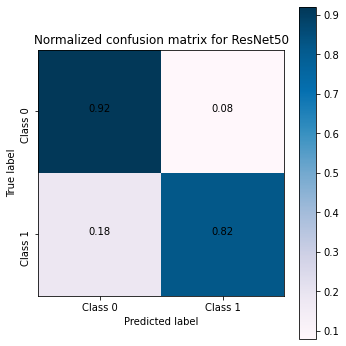

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.PuBu):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'], title='Normalized confusion matrix for ResNet50')
plt.show()

In [ ]:
fpr_resnet, tpr_resnet, thresholds = roc_curve(y_test, y_pred_prob)
auc_val_resnet = auc(fpr_resnet, tpr_resnet)

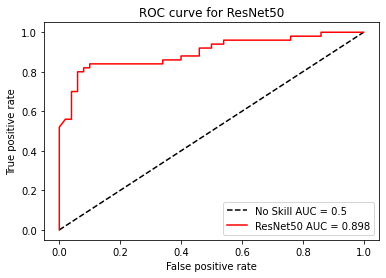

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr_resnet, tpr_resnet, label='ResNet50 AUC = {:.3f}'.format(auc_val_resnet), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for ResNet50')
plt.legend(loc='best')
plt.show()

In [ ]:
# accuracy: (tp + tn) / (tp + tn + fp +fn)
acc_resnet = accuracy_score(y_test, y_pred)
print('Accuracy : %f' % acc_resnet)

# f1: 2 tp / (2 tp + fp + fn)
f1_resnet = f1_score(y_test, y_pred)
print('F1 score : %f' % f1_resnet)

# recall: tp / (tp + fn)
recall_resnet = recall_score(y_test, y_pred)
print('Recall : %f' % recall_resnet)

# AUC
print('AUC : %f' % auc_val_resnet)

Accuracy : 0.870000
F1 score : 0.863158
Recall : 0.820000
AUC : 0.898000


In [ ]:
resnet_metrics = dict({'acc_resnet' : acc_resnet,
                    'f1_resnet' : f1_resnet,
                    'recall_resnet' : recall_resnet,
                    'auc_val_resnet' : auc_val_resnet,
                    'fpr_resnet' : fpr_resnet,
                    'tpr_resnet' : tpr_resnet})

In [ ]:
with open('/content/resnet50/resnet_metrics.pickle','wb') as f:
  pickle.dump(resnet_metrics, f)

In [ ]:
%%capture
! zip -r /content/resnet50.zip /content/resnet50/
! rm -rf /content/resnet50/

## InceptionV3 with retrained BatchNorm

### Setup & Preprocessing

In [ ]:
! mkdir /content/inceptionv3bn

In [ ]:
X_train_p = tf.keras.applications.inception_v3.preprocess_input(X_train)
X_test_p = tf.keras.applications.inception_v3.preprocess_input(X_test)
print(X_train_p.shape)
print(X_test_p.shape)

(646, 291, 407, 3)
(100, 291, 407, 3)


In [ ]:
# build the VGG16 network
inceptionbn_base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape = (med_h, med_w, 3))
inceptionbn_base.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 291, 407, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 145, 203, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 145, 203, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 145, 203, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
for layer in inceptionbn_base.layers:
  if layer.name[:5]!='batch':
    layer.trainable = False

In [ ]:
for layer in inceptionbn_base.layers:
  print(layer.name,layer.trainable)

input_4 False
conv2d False
batch_normalization True
activation False
conv2d_1 False
batch_normalization_1 True
activation_1 False
conv2d_2 False
batch_normalization_2 True
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 True
activation_3 False
conv2d_4 False
batch_normalization_4 True
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 True
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 True
batch_normalization_9 True
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 True
batch_normalization_7 True
batch_normalization_10 True
batch_normalization_11 True
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 True
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 True
batch_normalization_16 True
activation_13 False
act

In [ ]:
inceptionbn = Sequential()
inceptionbn.add(inceptionbn_base)
#vgg.layers[0].trainable = False
inceptionbn.add(layers.GlobalAveragePooling2D())
inceptionbn.add(layers.Dense(1024, activation='relu'))
inceptionbn.add(layers.Dropout(0.5))
inceptionbn.add(layers.Dense(512, activation='relu'))
inceptionbn.add(layers.Dropout(0.5))
inceptionbn.add(layers.Dense(256, activation='relu'))
inceptionbn.add(layers.Dropout(0.5))
inceptionbn.add(layers.Dense(128, activation='relu'))
inceptionbn.add(layers.Dropout(0.5))
inceptionbn.add(layers.Dense(64, activation='relu'))
inceptionbn.add(layers.Dense(1, activation='sigmoid'))
inceptionbn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 7, 11, 2048)       21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)              

In [ ]:
inceptionbn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20)
lr_dec_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=0.0001)
chkpt_save = tf.keras.callbacks.ModelCheckpoint("/content/inceptionv3bn/inceptionv3bn_ftr_extrctd/chkpt1", monitor="val_accuracy", save_best_only=True, mode = 'max', save_weights_only = True)

callbacks_list = [lr_dec_plateau, chkpt_save]

### Training

In [ ]:
num_epochs = 200
num_batch_size = 32 

In [ ]:
history = inceptionbn.fit(X_train_p, y_train,
                  epochs=num_epochs,
                  batch_size=num_batch_size,
                  validation_data=(X_test_p, y_test),
                  callbacks=callbacks_list)

Epoch 1/200
21/21 [==============================] - 15s 326ms/step - loss: 1.2086 - accuracy: 0.5154 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 2/200
21/21 [==============================] - 5s 223ms/step - loss: 0.8111 - accuracy: 0.5075 - val_loss: 0.7215 - val_accuracy: 0.5000
Epoch 3/200
21/21 [==============================] - 5s 224ms/step - loss: 0.8049 - accuracy: 0.5112 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 4/200
21/21 [==============================] - 5s 224ms/step - loss: 0.7519 - accuracy: 0.5105 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 5/200
21/21 [==============================] - 5s 223ms/step - loss: 0.7074 - accuracy: 0.5577 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 6/200
21/21 [==============================] - 5s 223ms/step - loss: 0.7143 - accuracy: 0.4931 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 7/200
21/21 [==============================] - 5s 223ms/step - loss: 0.7163 - accuracy: 0.5127 - val_loss: 0.6933 - val_accuracy: 0.490

In [ ]:
#saving history to plot losses/ metrics later
with open('/content/inceptionv3bn/inceptionv3bn_history.hist', 'wb') as f1:
  pickle.dump(history.history, f1)

### Reloading the model

In [ ]:
checkpoint_path_inceptionbn = '/content/inceptionv3bn/inceptionv3bn_ftr_extrctd/chkpt1'
inceptionbn.load_weights(checkpoint_path_inceptionbn)

In [ ]:
with open('/content/inceptionv3bn/inceptionv3bn_history.hist', 'rb') as f1:
  history_hist = pickle.load(f1)

In [ ]:
with open('/content/inceptionv3bn/inceptionbn_metrics.pickle','rb') as f:
  inceptionbn_metrics = pickle.load(f)

### Evaluation

In [ ]:
# Re-evaluate the model
loss_train_inceptionbn, acc_train_inceptionbn = inceptionbn.evaluate(X_train_p, y_train, verbose=2)

21/21 - 2s - loss: 2.8796e-04 - accuracy: 1.0000


In [ ]:
# Re-evaluate the model
loss_inceptionbn, acc_inceptionbn = inceptionbn.evaluate(X_test_p, y_test, verbose=2)

4/4 - 0s - loss: 1.2011 - accuracy: 0.8200


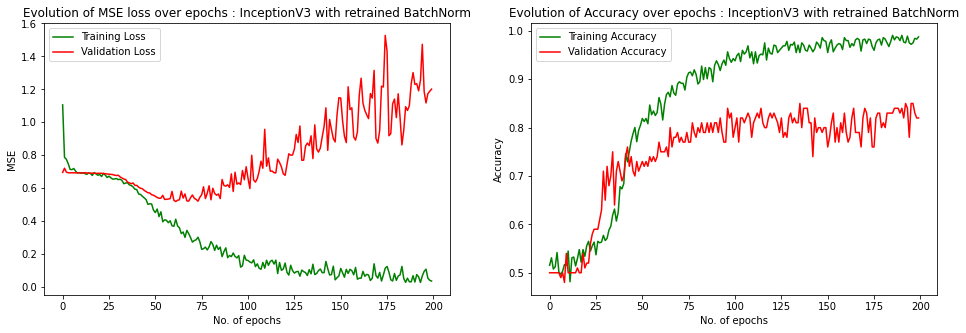

In [ ]:
#history_hist = history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

#MSE Loss
train_loss = history_hist['loss']
val_loss = history_hist['val_loss']


ax1.plot(range(0,len(train_loss)), train_loss, 'g', label='Training Loss')
ax1.plot(range(0,len(val_loss)), val_loss, 'r', label='Validation Loss')
ax1.set_title('Evolution of MSE loss over epochs : InceptionV3 with retrained BatchNorm')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('MSE')
ax1.legend()

#Accuracy
train_acc = history_hist['accuracy']
val_acc = history_hist['val_accuracy']

ax2.plot(range(0,len(train_acc)), train_acc, 'g', label='Training Accuracy')
ax2.plot(range(0,len(val_acc)), val_acc, 'r', label='Validation Accuracy')
ax2.set_title('Evolution of Accuracy over epochs : InceptionV3 with retrained BatchNorm')
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
y_pred_prob = inceptionbn.predict(X_test_p).flatten()
y_pred =(y_pred_prob > 0.5).astype("int32") # 0.5 threhold

<Figure size 432x288 with 0 Axes>

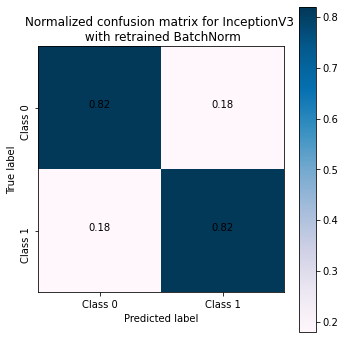

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.PuBu):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'], title='Normalized confusion matrix for InceptionV3 \n with retrained BatchNorm')
plt.show()

In [ ]:
fpr_inceptionbn, tpr_inceptionbn, thresholds = roc_curve(y_test, y_pred_prob)
auc_val_inceptionbn = auc(fpr_inceptionbn, tpr_inceptionbn)

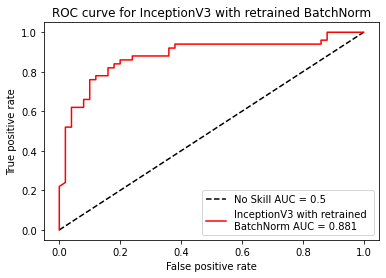

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr_inceptionbn, tpr_inceptionbn, label='InceptionV3 with retrained \nBatchNorm AUC = {:.3f}'.format(auc_val_inceptionbn), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for InceptionV3 with retrained BatchNorm')
plt.legend(loc='best')
plt.show()

In [ ]:
# accuracy: (tp + tn) / (tp + tn + fp +fn)
acc_inceptionbn = accuracy_score(y_test, y_pred)
print('Accuracy : %f' % acc_inceptionbn)

# f1: 2 tp / (2 tp + fp + fn)
f1_inceptionbn = f1_score(y_test, y_pred)
print('F1 score : %f' % f1_inceptionbn)

# recall: tp / (tp + fn)
recall_inceptionbn = recall_score(y_test, y_pred)
print('Recall : %f' % recall_inceptionbn)

# AUC
print('AUC : %f' % auc_val_inceptionbn)

Accuracy : 0.820000
F1 score : 0.820000
Recall : 0.820000
AUC : 0.881400


In [ ]:
inceptionbn_metrics = dict({'acc_inceptionbn' : acc_inceptionbn,
                    'f1_inceptionbn' : f1_inceptionbn,
                    'recall_inceptionbn' : recall_inceptionbn,
                    'auc_val_inceptionbn' : auc_val_inceptionbn,
                    'fpr_inceptionbn' : fpr_inceptionbn,
                    'tpr_inceptionbn' : tpr_inceptionbn})

In [ ]:
with open('/content/inceptionv3bn/inceptionbn_metrics.pickle','wb') as f:
  pickle.dump(inceptionbn_metrics, f)

In [ ]:
%%capture
! zip -r /content/inceptionv3bn.zip /content/inceptionv3bn/
! rm -rf /content/inceptionv3bn/

## EfficientNetB3 with retrained BatchNorm

### Setup & Preprocessing

In [ ]:
! mkdir /content/efficientnetb3bn

In [ ]:
X_train_p = tf.keras.applications.efficientnet.preprocess_input(X_train)
X_test_p = tf.keras.applications.efficientnet.preprocess_input(X_test)
print(X_train_p.shape)
print(X_test_p.shape)

(646, 291, 407, 3)
(100, 291, 407, 3)


In [ ]:
# build the VGG16 network
efficientnetbn_base = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape = (med_h, med_w, 3))
efficientnetbn_base.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 291, 407, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 291, 407, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 291, 407, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 293, 409, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [ ]:
for layer in efficientnetbn_base.layers:
  if layer.name.find('bn') == -1:
    layer.trainable = False

In [ ]:
for layer in efficientnetbn_base.layers:
  print(layer.name,layer.trainable)

input_6 False
rescaling_1 False
normalization_1 False
stem_conv_pad False
stem_conv False
stem_bn True
stem_activation False
block1a_dwconv False
block1a_bn True
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn True
block1b_dwconv False
block1b_bn True
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn True
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn True
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn True
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn True
block2b_expand_conv False
b

In [ ]:
efficientnetbn = Sequential()
efficientnetbn.add(efficientnetbn_base)
#vgg.layers[0].trainable = False
efficientnetbn.add(layers.GlobalAveragePooling2D())
efficientnetbn.add(layers.Dense(1024, activation='relu'))
efficientnetbn.add(layers.Dropout(0.5))
efficientnetbn.add(layers.Dense(512, activation='relu'))
efficientnetbn.add(layers.Dropout(0.5))
efficientnetbn.add(layers.Dense(256, activation='relu'))
efficientnetbn.add(layers.Dropout(0.5))
efficientnetbn.add(layers.Dense(128, activation='relu'))
efficientnetbn.add(layers.Dropout(0.5))
efficientnetbn.add(layers.Dense(64, activation='relu'))
efficientnetbn.add(layers.Dense(1, activation='sigmoid'))
efficientnetbn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 13, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)              

In [ ]:
efficientnetbn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20)
lr_dec_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=20)
                                                      #factor=0.5, patience=2, min_lr=0.0001)
chkpt_save = tf.keras.callbacks.ModelCheckpoint("/content/efficientnetb3bn/efficientnetb3bn_ftr_extrctd/chkpt1", monitor="val_accuracy", save_best_only=True, mode = 'max', save_weights_only = True)

callbacks_list = [lr_dec_plateau, chkpt_save]

### Training

In [ ]:
num_epochs = 200
num_batch_size = 32 

In [ ]:
history = efficientnetbn.fit(X_train_p, y_train,
                  epochs=num_epochs,
                  batch_size=num_batch_size,
                  validation_data=(X_test_p, y_test),
                  callbacks=callbacks_list)

Epoch 1/200
21/21 [==============================] - 26s 613ms/step - loss: 0.7616 - accuracy: 0.5183 - val_loss: 0.7052 - val_accuracy: 0.5000
Epoch 2/200
21/21 [==============================] - 11s 512ms/step - loss: 0.7206 - accuracy: 0.5158 - val_loss: 0.7044 - val_accuracy: 0.5000
Epoch 3/200
21/21 [==============================] - 11s 512ms/step - loss: 0.6979 - accuracy: 0.5552 - val_loss: 0.7078 - val_accuracy: 0.5000
Epoch 4/200
21/21 [==============================] - 11s 512ms/step - loss: 0.7020 - accuracy: 0.5342 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 5/200
21/21 [==============================] - 11s 512ms/step - loss: 0.6872 - accuracy: 0.5706 - val_loss: 0.7357 - val_accuracy: 0.5000
Epoch 6/200
21/21 [==============================] - 11s 513ms/step - loss: 0.6436 - accuracy: 0.6406 - val_loss: 0.7069 - val_accuracy: 0.5000
Epoch 7/200
21/21 [==============================] - 11s 512ms/step - loss: 0.5286 - accuracy: 0.7458 - val_loss: 0.7234 - val_accuracy:

In [ ]:
#saving history to plot losses/ metrics later
with open('/content/efficientnetb3bn/efficientnetb3bn_history.hist', 'wb') as f1:
  pickle.dump(history.history, f1)

### Reloading the model

In [ ]:
checkpoint_path_efficientnet = '/content/content/efficientnetb3bn/efficientnetb3bn_ftr_extrctd/chkpt1'
efficientnet.load_weights(checkpoint_path_efficientnet)

In [ ]:
with open('/content/efficientnetb3bn/efficientnetb3bn_history.hist', 'rb') as f1:
  history_hist = pickle.load(f1)

In [ ]:
with open('/content/efficientnetb3bn/efficientnetb3bn_metrics.pickle','rb') as f:
  efficientnet_metrics = pickle.load(f)

### Evaluation

In [ ]:
# Re-evaluate the model
loss_train_efficientnet, acc_train_efficientnet = efficientnetbn.evaluate(X_train_p, y_train, verbose=2)

21/21 - 3s - loss: 0.4525 - accuracy: 0.9350


In [ ]:
# Re-evaluate the model
loss_efficientnet, acc_efficientnet = efficientnetbn.evaluate(X_test_p, y_test, verbose=2)

4/4 - 0s - loss: 2.7331 - accuracy: 0.7000


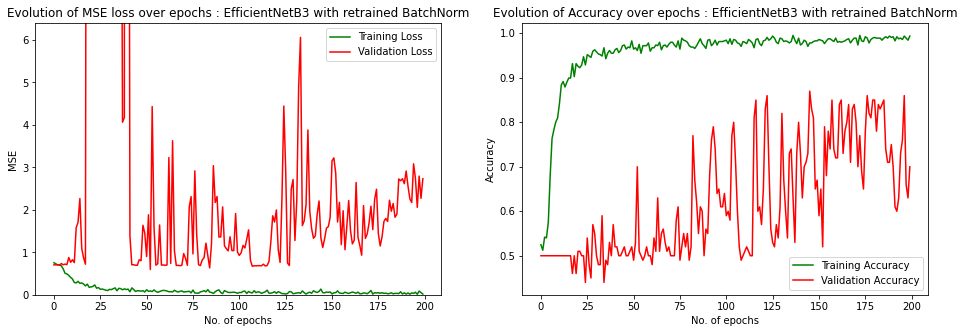

In [ ]:
#history_hist = history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

#MSE Loss
train_loss = history_hist['loss']
val_loss = history_hist['val_loss']


ax1.plot(range(0,len(train_loss)), train_loss, 'g', label='Training Loss')
ax1.plot(range(0,len(val_loss)), val_loss, 'r', label='Validation Loss')
ax1.set_title('Evolution of MSE loss over epochs : EfficientNetB3 with retrained BatchNorm')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('MSE')
ax1.set_ylim(0,6)
ax1.legend()

#Accuracy
train_acc = history_hist['accuracy']
val_acc = history_hist['val_accuracy']

ax2.plot(range(0,len(train_acc)), train_acc, 'g', label='Training Accuracy')
ax2.plot(range(0,len(val_acc)), val_acc, 'r', label='Validation Accuracy')
ax2.set_title('Evolution of Accuracy over epochs : EfficientNetB3 with retrained BatchNorm')
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
y_pred_prob = efficientnetbn.predict(X_test_p).flatten()
y_pred =(y_pred_prob > 0.5).astype("int32") # 0.5 threhold

<Figure size 432x288 with 0 Axes>

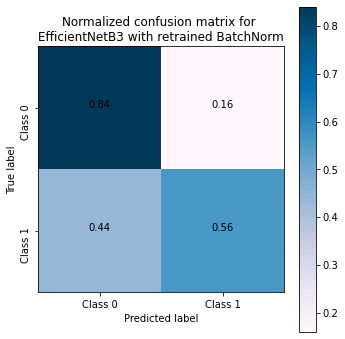

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.PuBu):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'], title='Normalized confusion matrix for \nEfficientNetB3 with retrained BatchNorm')
plt.show()

In [ ]:
fpr_efficientnetbn, tpr_efficientnetbn, thresholds = roc_curve(y_test, y_pred_prob)
auc_val_efficientnetbn = auc(fpr_efficientnetbn, tpr_efficientnetbn)

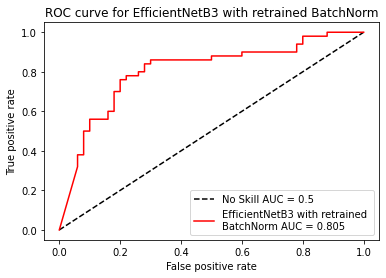

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')
plt.plot(fpr_efficientnetbn, tpr_efficientnetbn, label='EfficientNetB3 with retrained \nBatchNorm AUC = {:.3f}'.format(auc_val_efficientnetbn), color='red')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for EfficientNetB3 with retrained BatchNorm')
plt.legend(loc='best')
plt.show()

In [ ]:
# accuracy: (tp + tn) / (tp + tn + fp +fn)
acc_efficientnetbn = accuracy_score(y_test, y_pred)
print('Accuracy : %f' % acc_efficientnetbn)

# f1: 2 tp / (2 tp + fp + fn)
f1_efficientnetbn = f1_score(y_test, y_pred)
print('F1 score : %f' % f1_efficientnetbn)

# recall: tp / (tp + fn)
recall_efficientnetbn = recall_score(y_test, y_pred)
print('Recall : %f' % recall_efficientnetbn)

# AUC
print('AUC : %f' % auc_val_efficientnetbn)

Accuracy : 0.700000
F1 score : 0.651163
Recall : 0.560000
AUC : 0.805200


In [ ]:
efficientnetbn_metrics = dict({'acc_efficientnetbn' : acc_efficientnetbn,
                    'f1_efficientnetbn' : f1_efficientnetbn,
                    'recall_efficientnetbn' : recall_efficientnetbn,
                    'auc_val_efficientnetbn' : auc_val_efficientnetbn,
                    'fpr_efficientnetbn' : fpr_efficientnetbn,
                    'tpr_efficientnetbn' : tpr_efficientnetbn})

In [ ]:
with open('/content/efficientnetb3bn/efficientnetb3bn_metrics.pickle','wb') as f:
  pickle.dump(efficientnetbn_metrics, f)

In [ ]:
%%capture
! zip -r /content/efficientnetb3bn.zip /content/efficientnetb3bn/
! rm -rf /content/efficientnetb3bn/

# Comparsion & Evaluation

In [7]:
baselinenet_metrics = {'acc_baselinenet': 0.75,
 'auc_val_baselinenet': 0.8937999999999999,
 'f1_baselinenet': 0.7899159663865546,
 'fpr_baselinenet': np.array([0.  , 0.02, 0.02, 0.04, 0.04, 0.06, 0.06, 0.12, 0.12, 0.14, 0.14,
        0.18, 0.18, 0.32, 0.32, 0.4 , 0.4 , 0.42, 0.42, 0.5 , 0.5 , 0.54,
        0.54, 0.76, 0.76, 1.  ]),
 'recall_baselinenet': 0.94,
 'tpr_baselinenet': np.array([0.  , 0.02, 0.52, 0.52, 0.68, 0.68, 0.7 , 0.7 , 0.78, 0.78, 0.8 ,
        0.8 , 0.86, 0.86, 0.9 , 0.9 , 0.92, 0.92, 0.94, 0.94, 0.96, 0.96,
        0.98, 0.98, 1.  , 1.  ])}

In [8]:
vgg_metrics = {'acc_vgg': 0.86,
 'auc_val_vgg': 0.9094,
 'f1_vgg': 0.8571428571428572,
 'fpr_vgg': np.array([0.  , 0.06, 0.06, 0.08, 0.08, 0.12, 0.12, 0.26, 0.26, 0.32, 0.32,
        0.34, 0.34, 0.44, 0.44, 0.56, 0.56, 0.58, 0.58, 1.  ]),
 'recall_vgg': 0.84,
 'tpr_vgg': np.array([0.  , 0.74, 0.78, 0.78, 0.84, 0.84, 0.86, 0.86, 0.88, 0.88, 0.9 ,
        0.9 , 0.92, 0.92, 0.96, 0.96, 0.98, 0.98, 1.  , 1.  ])}

In [9]:
densenet_metrics = {'acc_densenet': 0.88,
 'auc_val_densenet': 0.9324,
 'f1_densenet': 0.8723404255319149,
 'fpr_densenet': np.array([0.  , 0.04, 0.04, 0.06, 0.06, 0.08, 0.08, 0.16, 0.16, 0.22, 0.22,
        0.34, 0.34, 0.4 , 0.4 , 0.62, 0.62, 1.  ]),
 'recall_densenet': 0.82,
 'tpr_densenet': np.array([0.  , 0.76, 0.78, 0.78, 0.82, 0.82, 0.86, 0.86, 0.9 , 0.9 , 0.92,
        0.92, 0.94, 0.94, 0.98, 0.98, 1.  , 1.  ])}

In [10]:
resnet_metrics = {'acc_resnet': 0.87,
 'auc_val_resnet': 0.8979999999999999,
 'f1_resnet': 0.8631578947368421,
 'fpr_resnet': np.array([0.  , 0.  , 0.02, 0.04, 0.04, 0.06, 0.06, 0.08, 0.08, 0.1 , 0.1 ,
        0.34, 0.34, 0.4 , 0.4 , 0.46, 0.46, 0.5 , 0.5 , 0.54, 0.54, 0.76,
        0.76, 0.86, 0.86, 0.94, 1.  ]),
 'recall_resnet': 0.82,
 'tpr_resnet': np.array([0.  , 0.52, 0.56, 0.56, 0.7 , 0.7 , 0.8 , 0.8 , 0.82, 0.82, 0.84,
        0.84, 0.86, 0.86, 0.88, 0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96,
        0.98, 0.98, 1.  , 1.  , 1.  ])}

In [11]:
inceptionbn_metrics = {'acc_inceptionbn': 0.82,
 'auc_val_inceptionbn': 0.8814,
 'f1_inceptionbn': 0.82,
 'fpr_inceptionbn': np.array([0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.04, 0.04, 0.08, 0.08, 0.1 ,
        0.1 , 0.12, 0.12, 0.16, 0.16, 0.18, 0.18, 0.2 , 0.2 , 0.24, 0.24,
        0.36, 0.36, 0.38, 0.38, 0.86, 0.86, 0.88, 0.88, 1.  ]),
 'recall_inceptionbn': 0.82,
 'tpr_inceptionbn': np.array([0.  , 0.1 , 0.14, 0.22, 0.24, 0.52, 0.52, 0.62, 0.62, 0.66, 0.66,
        0.76, 0.76, 0.78, 0.78, 0.82, 0.82, 0.84, 0.84, 0.86, 0.86, 0.88,
        0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 1.  , 1.  ])}

In [12]:
efficientnetbn_metrics = {'acc_efficientnetbn': 0.7,
 'auc_val_efficientnetbn': 0.8051999999999999,
 'f1_efficientnetbn': 0.6511627906976745,
 'fpr_efficientnetbn': np.array([0.  , 0.06, 0.06, 0.08, 0.08, 0.1 , 0.1 , 0.16, 0.16, 0.18, 0.18,
        0.2 , 0.2 , 0.22, 0.22, 0.26, 0.26, 0.28, 0.28, 0.3 , 0.3 , 0.5 ,
        0.5 , 0.6 , 0.6 , 0.78, 0.78, 0.8 , 0.8 , 0.88, 0.88, 1.  ]),
 'recall_efficientnetbn': 0.56,
 'tpr_efficientnetbn': np.array([0.  , 0.32, 0.38, 0.38, 0.5 , 0.5 , 0.56, 0.56, 0.6 , 0.6 , 0.7 ,
        0.7 , 0.76, 0.76, 0.78, 0.78, 0.8 , 0.8 , 0.84, 0.84, 0.86, 0.86,
        0.88, 0.88, 0.9 , 0.9 , 0.94, 0.94, 0.98, 0.98, 1.  , 1.  ])}

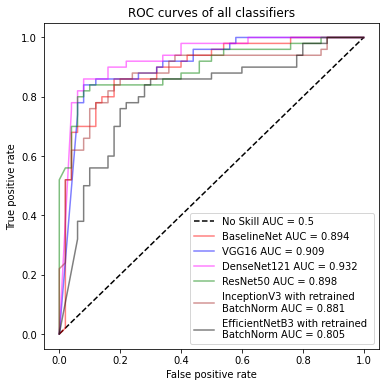

In [ ]:
plt.figure(figsize=(6,6))

plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill AUC = 0.5')

plt.plot(baselinenet_metrics['fpr_baselinenet'], baselinenet_metrics['tpr_baselinenet'], 
         label='BaselineNet AUC = {:.3f}'.format(baselinenet_metrics['auc_val_baselinenet']), color='red', alpha = 0.5)

plt.plot(vgg_metrics['fpr_vgg'], vgg_metrics['tpr_vgg'], 
         label='VGG16 AUC = {:.3f}'.format(vgg_metrics['auc_val_vgg']), color='blue', alpha = 0.5)

plt.plot(densenet_metrics['fpr_densenet'], densenet_metrics['tpr_densenet'], 
         label='DenseNet121 AUC = {:.3f}'.format(densenet_metrics['auc_val_densenet']), color='magenta', alpha = 0.5)

plt.plot(resnet_metrics['fpr_resnet'], resnet_metrics['tpr_resnet'], 
         label='ResNet50 AUC = {:.3f}'.format(resnet_metrics['auc_val_resnet']), color='green', alpha = 0.5)

plt.plot(inceptionbn_metrics['fpr_inceptionbn'], inceptionbn_metrics['tpr_inceptionbn'], 
         label='InceptionV3 with retrained \nBatchNorm AUC = {:.3f}'.format(inceptionbn_metrics['auc_val_inceptionbn']), 
         color='brown', alpha = 0.5)

plt.plot(efficientnetbn_metrics['fpr_efficientnetbn'], efficientnetbn_metrics['tpr_efficientnetbn'], 
         label='EfficientNetB3 with retrained \nBatchNorm AUC = {:.3f}'.format(efficientnetbn_metrics['auc_val_efficientnetbn']), 
         color='black', alpha = 0.5)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves of all classifiers')
plt.legend(loc='best')
plt.show()

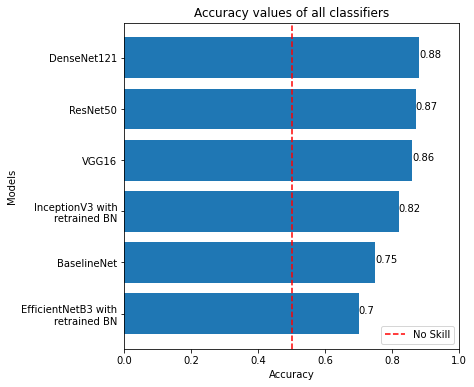

In [ ]:
x = np.array(['BaselineNet','VGG16','DenseNet121','ResNet50',
     'InceptionV3 with\nretrained BN', 'EfficientNetB3 with\nretrained BN'])
y = np.array([baselinenet_metrics['acc_baselinenet'],vgg_metrics['acc_vgg'],
     densenet_metrics['acc_densenet'],resnet_metrics['acc_resnet'],
     inceptionbn_metrics['acc_inceptionbn'],efficientnetbn_metrics['acc_efficientnetbn']])

plt.figure(figsize=(6,6))
plt.barh(x[np.argsort(y)],y[np.argsort(y)])

for index, value in enumerate(y[np.argsort(y)]):
    plt.text(value, index, str(value))

plt.axvline(x=0.5,color='red', linestyle='dashed', label = 'No Skill')
#plt.xticks(rotation=90)
plt.ylabel('Models')
plt.xlabel('Accuracy')
plt.title('Accuracy values of all classifiers')
plt.xlim(0,1.0)
plt.legend(loc='best')
plt.show()

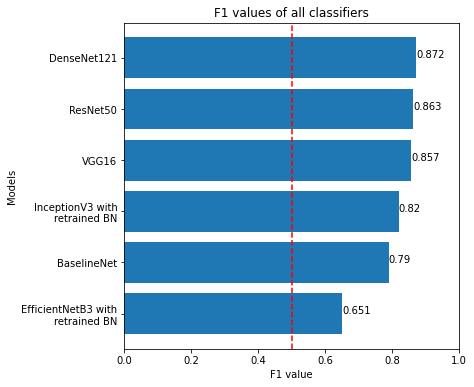

In [ ]:
x = np.array(['BaselineNet','VGG16','DenseNet121','ResNet50',
     'InceptionV3 with\nretrained BN', 'EfficientNetB3 with\nretrained BN'])
y = np.array([baselinenet_metrics['f1_baselinenet'],vgg_metrics['f1_vgg'],
     densenet_metrics['f1_densenet'],resnet_metrics['f1_resnet'],
     inceptionbn_metrics['f1_inceptionbn'],efficientnetbn_metrics['f1_efficientnetbn']])

plt.figure(figsize=(6,6))
plt.barh(x[np.argsort(y)],y[np.argsort(y)])

for index, value in enumerate(y[np.argsort(y)]):
    plt.text(value, index, str(np.round(value,3)))

plt.axvline(x=0.5,color='red', linestyle='dashed')
#plt.xticks(rotation=90)
plt.ylabel('Models')
plt.xlabel('F1 value')
plt.title('F1 values of all classifiers')
plt.xlim(0,1.0)
#plt.legend(loc='best')
plt.show()

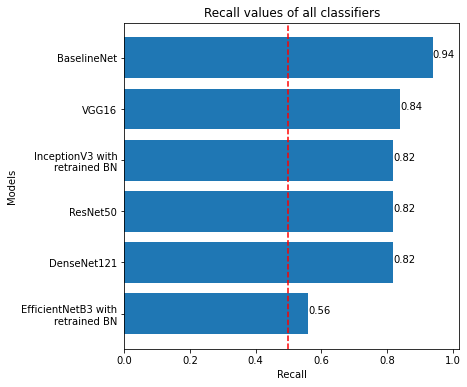

In [ ]:
x = np.array(['BaselineNet','VGG16','DenseNet121','ResNet50',
     'InceptionV3 with\nretrained BN', 'EfficientNetB3 with\nretrained BN'])
y = np.array([baselinenet_metrics['recall_baselinenet'],vgg_metrics['recall_vgg'],
     densenet_metrics['recall_densenet'],resnet_metrics['recall_resnet'],
     inceptionbn_metrics['recall_inceptionbn'],efficientnetbn_metrics['recall_efficientnetbn']])

plt.figure(figsize=(6,6))
plt.barh(x[np.argsort(y)],y[np.argsort(y)])

for index, value in enumerate(y[np.argsort(y)]):
    plt.text(value, index, str(np.round(value,3)))

plt.axvline(x=0.5,color='red', linestyle='dashed')
#plt.xticks(rotation=90)
plt.ylabel('Models')
plt.xlabel('Recall')
plt.title('Recall values of all classifiers')
plt.xlim(0,1.02)
#plt.legend(loc='best')
plt.show()

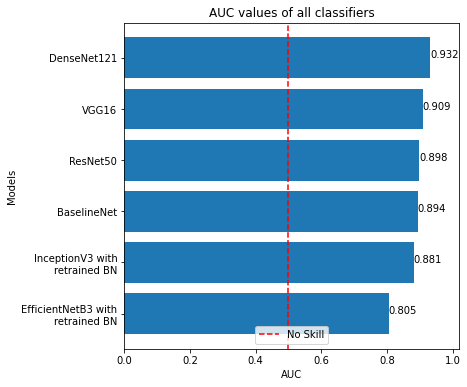

In [ ]:
x = np.array(['BaselineNet','VGG16','DenseNet121','ResNet50',
     'InceptionV3 with\nretrained BN', 'EfficientNetB3 with\nretrained BN'])
y = np.array([baselinenet_metrics['auc_val_baselinenet'],vgg_metrics['auc_val_vgg'],
     densenet_metrics['auc_val_densenet'],resnet_metrics['auc_val_resnet'],
     inceptionbn_metrics['auc_val_inceptionbn'],efficientnetbn_metrics['auc_val_efficientnetbn']])

plt.figure(figsize=(6,6))
plt.barh(x[np.argsort(y)],y[np.argsort(y)])

for index, value in enumerate(y[np.argsort(y)]):
    plt.text(value, index, str(np.round(value,3)))

plt.axvline(x=0.5,color='red', linestyle='dashed', label = 'No Skill')
#plt.xticks(rotation=90)
plt.ylabel('Models')
plt.xlabel('AUC')
plt.title('AUC values of all classifiers')
plt.xlim(0,1.02)
plt.legend(loc='lower center')
plt.show()

In [5]:
baselinenet_num_params_train = 84353
baselinenet_num_params_nontrain = 384
baselinenet_num_params_total = 84737

vgg_num_params_train = 172545
vgg_num_params_nontrain = 14714688
vgg_num_params_total = 14887233

densenet_num_params_train = 697345
densenet_num_params_nontrain = 7037504
densenet_num_params_total = 7734849

resnet_num_params_train = 2795521
resnet_num_params_nontrain = 23587712
resnet_num_params_total = 26383233

inception_num_params_train = 2812737
inception_num_params_nontrain = 21785568
inception_num_params_total = 24598305

efficientnet_num_params_train = 2358529
efficientnet_num_params_nontrain = 10696239
efficientnet_num_params_total = 13054768

In [15]:
x_models = np.array(['BaselineNet','VGG16','DenseNet121','ResNet50',
     'InceptionV3 with\nretrained BN', 'EfficientNetB3 with\nretrained BN'])

x_num_train_params = np.array([baselinenet_num_params_train, vgg_num_params_train, densenet_num_params_train,
                      resnet_num_params_train, inception_num_params_train, efficientnet_num_params_train])

x_num_nontrain_params = np.array([baselinenet_num_params_nontrain, vgg_num_params_nontrain, densenet_num_params_nontrain,
                      resnet_num_params_nontrain, inception_num_params_nontrain, efficientnet_num_params_nontrain])

x_num_total_params = np.array([baselinenet_num_params_total, vgg_num_params_total, densenet_num_params_total,
                      resnet_num_params_total, inception_num_params_total, efficientnet_num_params_total])

y_acc = np.array([baselinenet_metrics['acc_baselinenet'],vgg_metrics['acc_vgg'],
     densenet_metrics['acc_densenet'],resnet_metrics['acc_resnet'],
     inceptionbn_metrics['acc_inceptionbn'],efficientnetbn_metrics['acc_efficientnetbn']])

y_recall = np.array([baselinenet_metrics['recall_baselinenet'],vgg_metrics['recall_vgg'],
     densenet_metrics['recall_densenet'],resnet_metrics['recall_resnet'],
     inceptionbn_metrics['recall_inceptionbn'],efficientnetbn_metrics['recall_efficientnetbn']])

y_f1 = np.array([baselinenet_metrics['f1_baselinenet'],vgg_metrics['f1_vgg'],
     densenet_metrics['f1_densenet'],resnet_metrics['f1_resnet'],
     inceptionbn_metrics['f1_inceptionbn'],efficientnetbn_metrics['f1_efficientnetbn']])

y_auc = np.array([baselinenet_metrics['auc_val_baselinenet'],vgg_metrics['auc_val_vgg'],
     densenet_metrics['auc_val_densenet'],resnet_metrics['auc_val_resnet'],
     inceptionbn_metrics['auc_val_inceptionbn'],efficientnetbn_metrics['auc_val_efficientnetbn']])

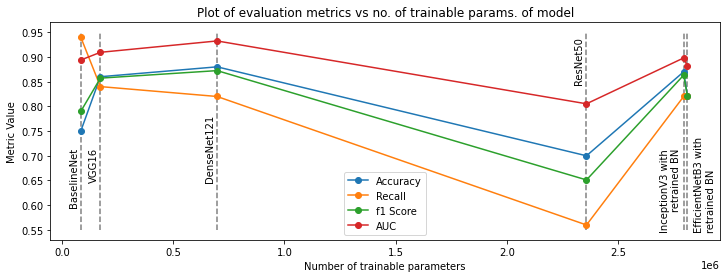

-52066.20000000001 2949156.2


In [ ]:
plt.figure(figsize=(12,4))

plt.plot(x_num_train_params[np.argsort(x_num_train_params)],y_acc[np.argsort(x_num_train_params)],'-o',label='Accuracy')
plt.plot(x_num_train_params[np.argsort(x_num_train_params)],y_recall[np.argsort(x_num_train_params)],'-o',label='Recall')
plt.plot(x_num_train_params[np.argsort(x_num_train_params)],y_f1[np.argsort(x_num_train_params)],'-o',label='f1 Score')
plt.plot(x_num_train_params[np.argsort(x_num_train_params)],y_auc[np.argsort(x_num_train_params)],'-o',label='AUC')

plt.vlines(x=x_num_train_params[np.argsort(x_num_train_params)],ymin = 0.55 ,ymax = 0.95 , 
           color = 'black', linestyle= 'dashed',alpha=0.5)

plt.text(x_num_train_params[np.argsort(x_num_train_params)][0]-10000, 0.60, 
         x_models[0], rotation=90,horizontalalignment='right')

plt.text(x_num_train_params[np.argsort(x_num_train_params)][1]-5000, 0.65, 
         x_models[1], rotation=90,horizontalalignment='right')

plt.text(x_num_train_params[np.argsort(x_num_train_params)][2]-10000, 0.65, 
         x_models[2], rotation=90,horizontalalignment='right')

plt.text(x_num_train_params[np.argsort(x_num_train_params)][3]-10000, 0.85, 
         x_models[3], rotation=90,horizontalalignment='right')

plt.text(x_num_train_params[np.argsort(x_num_train_params)][4]-10000, 0.55, 
         x_models[4], rotation=90,horizontalalignment='right')

plt.text(x_num_train_params[np.argsort(x_num_train_params)][5]+30000, 0.55, 
         x_models[5], rotation=90,horizontalalignment='left')

l,r=plt.xlim()
plt.xlim(l,r+10000)

plt.xlabel('Number of trainable parameters')
plt.ylabel('Metric Value')
plt.legend(loc='lower center')
plt.title('Plot of evaluation metrics vs no. of trainable params. of model')
plt.show()

#print(l,r)

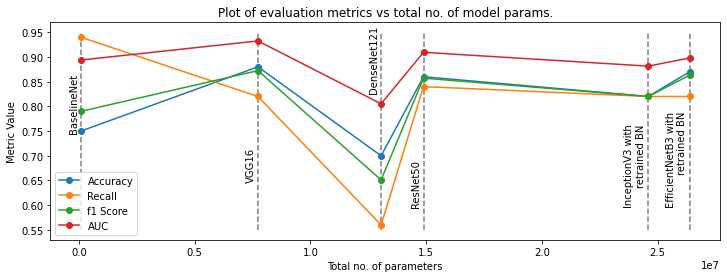

In [ ]:
plt.figure(figsize=(12,4))

plt.plot(x_num_total_params[np.argsort(x_num_total_params)],y_acc[np.argsort(x_num_total_params)],'-o',label='Accuracy')
plt.plot(x_num_total_params[np.argsort(x_num_total_params)],y_recall[np.argsort(x_num_total_params)],'-o',label='Recall')
plt.plot(x_num_total_params[np.argsort(x_num_total_params)],y_f1[np.argsort(x_num_total_params)],'-o',label='f1 Score')
plt.plot(x_num_total_params[np.argsort(x_num_total_params)],y_auc[np.argsort(x_num_total_params)],'-o',label='AUC')


plt.vlines(x=x_num_total_params[np.argsort(x_num_total_params)],ymin = 0.55 ,ymax = 0.95 , 
           color = 'black', linestyle= 'dashed',alpha=0.5)

plt.text(x_num_total_params[np.argsort(x_num_total_params)][0]-100000, 0.75, 
         x_models[0], rotation=90,horizontalalignment='right')

plt.text(x_num_total_params[np.argsort(x_num_total_params)][1]-100000, 0.65, 
         x_models[1], rotation=90,horizontalalignment='right')

plt.text(x_num_total_params[np.argsort(x_num_total_params)][2]-100000, 0.83, 
         x_models[2], rotation=90,horizontalalignment='right')

plt.text(x_num_total_params[np.argsort(x_num_total_params)][3]-100000, 0.60, 
         x_models[3], rotation=90,horizontalalignment='right')

plt.text(x_num_total_params[np.argsort(x_num_total_params)][4]-100000, 0.60, 
         x_models[4], rotation=90,horizontalalignment='right')

plt.text(x_num_total_params[np.argsort(x_num_total_params)][5]-100000, 0.60, 
         x_models[5], rotation=90,horizontalalignment='right')


plt.xlabel('Total no. of parameters')
plt.ylabel('Metric Value')
plt.legend(loc='best')
plt.title('Plot of evaluation metrics vs total no. of model params.')
plt.show()

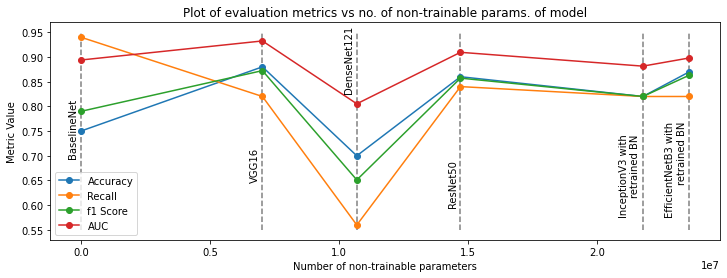

In [37]:
plt.figure(figsize=(12,4))

plt.plot(x_num_nontrain_params[np.argsort(x_num_nontrain_params)],y_acc[np.argsort(x_num_nontrain_params)],'-o',label='Accuracy')
plt.plot(x_num_nontrain_params[np.argsort(x_num_nontrain_params)],y_recall[np.argsort(x_num_nontrain_params)],'-o',label='Recall')
plt.plot(x_num_nontrain_params[np.argsort(x_num_nontrain_params)],y_f1[np.argsort(x_num_nontrain_params)],'-o',label='f1 Score')
plt.plot(x_num_nontrain_params[np.argsort(x_num_nontrain_params)],y_auc[np.argsort(x_num_nontrain_params)],'-o',label='AUC')

plt.vlines(x=x_num_nontrain_params[np.argsort(x_num_nontrain_params)],ymin = 0.55 ,ymax = 0.95 , 
           color = 'black', linestyle= 'dashed',alpha=0.5)

plt.text(x_num_nontrain_params[np.argsort(x_num_nontrain_params)][0]-100000, 0.70, 
         x_models[0], rotation=90,horizontalalignment='right')

plt.text(x_num_nontrain_params[np.argsort(x_num_nontrain_params)][1]-100000, 0.65, 
         x_models[1], rotation=90,horizontalalignment='right')

plt.text(x_num_nontrain_params[np.argsort(x_num_nontrain_params)][2]-100000, 0.83, 
         x_models[2], rotation=90,horizontalalignment='right')

plt.text(x_num_nontrain_params[np.argsort(x_num_nontrain_params)][3]-100000, 0.60, 
         x_models[3], rotation=90,horizontalalignment='right')

plt.text(x_num_nontrain_params[np.argsort(x_num_nontrain_params)][4]-100000, 0.58, 
         x_models[4], rotation=90,horizontalalignment='right')

plt.text(x_num_nontrain_params[np.argsort(x_num_nontrain_params)][5]-100000, 0.58, 
         x_models[5], rotation=90,horizontalalignment='right')

l,r=plt.xlim()
plt.xlim(l,r+10000)

plt.xlabel('Number of non-trainable parameters')
plt.ylabel('Metric Value')
plt.legend(loc='best')
plt.title('Plot of evaluation metrics vs no. of non-trainable params. of model')
plt.show()

#print(l,r)